# Giới thiệu

In [2]:
DATA_ROOT = "../../data/Traffic_flow-HCM"

# Thư viện sử dụng

In [58]:
import numpy as np
import pandas as pd

import squarify

import plotly.express as px
import plotly.graph_objects as go
import geopandas as gpd

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns

# Tiền xử lý các input

## streets.csv

Thông tin đoạn đường ở TP. HCM. Có 5553 dòng, 6 cột

In [112]:
streets_df = pd.read_csv(f"{DATA_ROOT}/streets.csv")
preprocess_streets_df = streets_df.copy() # Tạo một biến riêng để tiền xử lý
streets_df.shape

(5553, 5)

In [109]:
streets_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5553 entries, 0 to 5552
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   _id           5553 non-null   int64  
 1   level         5553 non-null   int64  
 2   max_velocity  987 non-null    float64
 3   name          3948 non-null   object 
 4   type          5553 non-null   object 
dtypes: float64(1), int64(2), object(2)
memory usage: 217.0+ KB


In [111]:
streets_df.head()

,_id,level,max_velocity,name,type
0,31096786,1,80.0,Quốc Lộ 1,trunk
1,32575737,4,NaN,NaN,unclassified
2,32575794,4,NaN,Chu Văn An,unclassified
3,32575820,4,NaN,Nguyễn Văn Bá,tertiary
4,32575823,4,NaN,Nguyễn Thị Nhỏ,tertiary


In [114]:
# Số lượng các giá trị bị thiếu
streets_df.isnull().sum()

_id                0
level              0
max_velocity    4566
name            1605
type               0
dtype: int64

In [113]:
#  Tỉ lệ các giá trị bị thiếu
streets_df.isnull().sum()*100/len(streets_df)

_id              0.000000
level            0.000000
max_velocity    82.225824
name            28.903296
type             0.000000
dtype: float64

In [8]:
streets_df.duplicated().sum()

np.int64(0)

### Id đoạn đường

Giá trị duy nhất để sử dụng trong `segments.csv`, `segments_status.csv`, và `train.csv`

### Cấp công trình giao thông

In [9]:
level_arr = streets_df["level"]
level_counts = level_arr.value_counts()

In [10]:
level_counts

level
4    2930
3    1268
2     889
1     466
Name: count, dtype: int64

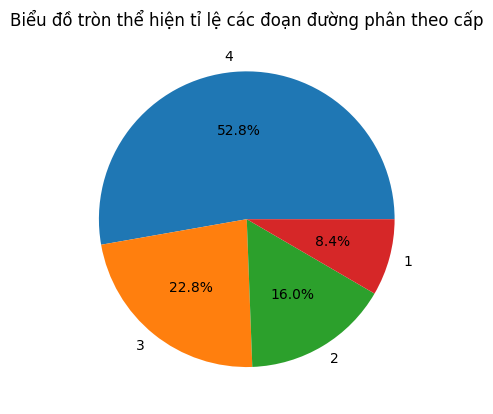

In [11]:
plt.pie(level_counts, labels=level_counts.index, 
        autopct='%1.1f%%')
plt.title("Biểu đồ tròn thể hiện tỉ lệ các đoạn đường phân theo cấp")
plt.show()

Đoạn đường cấp 4 chiếm nhiều số lượng với 2930 đoạn đường và cấp 1 chiếm số lượng ít nhất với 466 đoạn đường

### Tốc độ tối đa cho phép

In [20]:
velocity_arr = streets_df[streets_df["max_velocity"].notnull()]["max_velocity"]
velocity_arr.min(), \
velocity_arr.max()

(np.float64(10.0), np.float64(120.0))

In [23]:
velocity_counts = velocity_arr.value_counts()
velocity_counts

max_velocity
60.0     422
80.0     180
50.0     150
40.0     145
30.0      25
70.0      18
20.0      15
10.0       9
100.0      9
45.0       7
120.0      7
Name: count, dtype: int64

#### Trực quan tốc độ tối đa

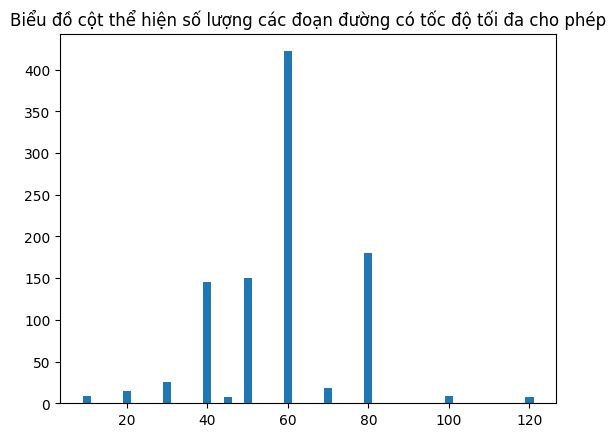

In [30]:
plt.bar(velocity_counts.index, velocity_counts, 2)
plt.title("Biểu đồ cột thể hiện số lượng các đoạn đường có tốc độ tối đa cho phép")
plt.show()

In [16]:
# Xem thử một vài đoạn đường có mốc 10km/h
streets_df[streets_df["max_velocity"] == 10].head()

,_id,level,max_velocity,name,type
1337,196966072,3,10.0,Đường dẫn ga Quốc nội,secondary_link
1724,216585724,4,10.0,Đường dẫn sảnh đến Quốc tế,tertiary
1727,216585806,4,10.0,Đường dẫn Ga Quốc Nội,tertiary
2830,326849838,4,10.0,Đường dẫn Ga Quốc Nội,tertiary
2831,326849839,3,10.0,NaN,secondary_link


Biểu đồ thể hiện mốc 60km/h chiếm số lượng nhiều nhất với 422 đoạn đường và 2 mốc ít nhất là 120km/h (dùng cho đường cao tốc) và 45km/h. Với mốc thấp nhất là 10km/h và cao nhất là 120km/h do lối đặc biệt. Tuy nhiên không phải đoạn đường nào cũng sẽ được sử dụng

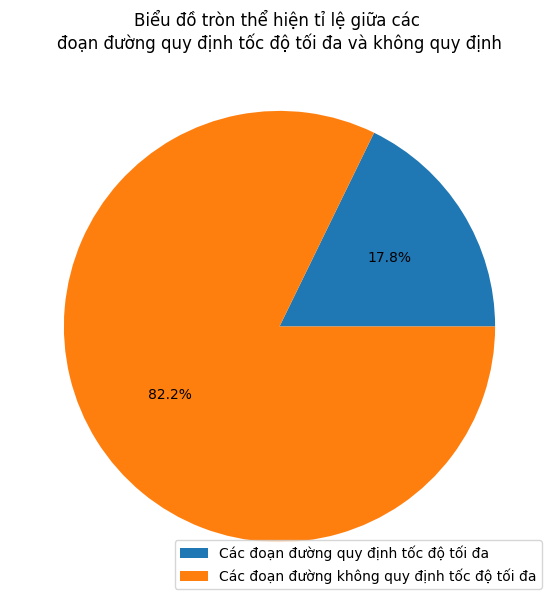

In [42]:
n_max_velocity = len(velocity_arr)
n_non_max_velocity = len(streets_df) - n_max_velocity

plt.figure(figsize=(7, 7))
plt.pie(
    [n_max_velocity, n_non_max_velocity], 
    autopct='%1.1f%%'
)
plt.legend(
    ["Các đoạn đường quy định tốc độ tối đa", 
    "Các đoạn đường không quy định tốc độ tối đa"],
    loc="lower right"
)
plt.title("Biểu đồ tròn thể hiện tỉ lệ giữa các \n" \
            "đoạn đường quy định tốc độ tối đa và không quy định")
plt.show()

#### Thế giá trị bị thiếu cho các đoạn đường không có giới hạn tối đa

Thế các giá trị bị thiếu trong trường hợp có xử lý trong tương lai

In [19]:
preprocess_streets_df["max_velocity"] = preprocess_streets_df["max_velocity"].fillna(-1)
preprocess_streets_df.head()

,_id,level,max_velocity,name,type
0,31096786,1,80.0,Quốc Lộ 1,trunk
1,32575737,4,-1.0,NaN,unclassified
2,32575794,4,-1.0,Chu Văn An,unclassified
3,32575820,4,-1.0,Nguyễn Văn Bá,tertiary
4,32575823,4,-1.0,Nguyễn Thị Nhỏ,tertiary


### Tên đường

#### Thống kê số lượng đoạn đường theo tên

In [21]:
name_arr = streets_df[streets_df["name"].notnull()]["name"]
print(len(name_arr))
name_arr.unique()

3948


array(['Quốc Lộ 1', 'Chu Văn An', 'Nguyễn Văn Bá', ..., 'X2', 'X1',
       'Đình Nghi Xuân'], shape=(1048,), dtype=object)

In [22]:
# Số đoạn đường ít nhất, nhiều nhất theo tên
name_counts = name_arr.value_counts()
name_counts.min(), \
name_counts.max()

(np.int64(1), np.int64(169))

#### Trực quan top 5 tên đường có nhiều đoạn đường nhất trong dataset

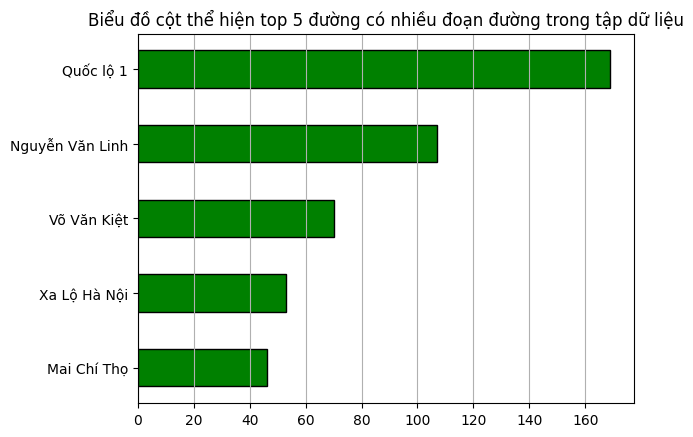

In [15]:
name_counts_head = name_counts.head(5)
plt.barh(y=name_counts_head.index, width=name_counts_head, color="green", edgecolor="black", height=0.5)
plt.title("Biểu đồ cột thể hiện top 5 đường có nhiều đoạn đường trong tập dữ liệu")
plt.gca().invert_yaxis()
plt.grid(axis="x")
plt.show()

In [16]:
# Xem mẫu "Quốc lộ 1"
streets_df[streets_df["name"] == "Quốc lộ 1"].head()

,_id,level,max_velocity,name,type
256,32583460,3,NaN,Quốc lộ 1,trunk_link
458,32928899,1,60.0,Quốc lộ 1,trunk
463,32928907,1,60.0,Quốc lộ 1,trunk
527,33285459,1,80.0,Quốc lộ 1,trunk
528,33285465,1,80.0,Quốc lộ 1,trunk


#### Thé giá trị bị thiếu cho tên đường

In [24]:
preprocess_streets_df["name"] = preprocess_streets_df["name"].fillna("(không tên)")
preprocess_streets_df.head()

,_id,level,max_velocity,name,type
0,31096786,1,80.0,Quốc Lộ 1,trunk
1,32575737,4,-1.0,(không tên),unclassified
2,32575794,4,-1.0,Chu Văn An,unclassified
3,32575820,4,-1.0,Nguyễn Văn Bá,tertiary
4,32575823,4,-1.0,Nguyễn Thị Nhỏ,tertiary


### Loại đường

In [17]:
type_arr = streets_df[streets_df["name"].notnull()]["type"]
print(len(type_arr))
type_arr.unique()

3948


array(['trunk', 'unclassified', 'tertiary', 'secondary', 'primary_link',
       'primary', 'trunk_link', 'tertiary_link', 'secondary_link',
       'motorway', 'motorway_link'], dtype=object)

In [18]:
type_counts = type_arr.value_counts()
type_counts

type
tertiary          1465
primary            800
secondary          525
unclassified       417
trunk              410
trunk_link         110
primary_link        97
motorway            40
secondary_link      31
motorway_link       27
tertiary_link       26
Name: count, dtype: int64

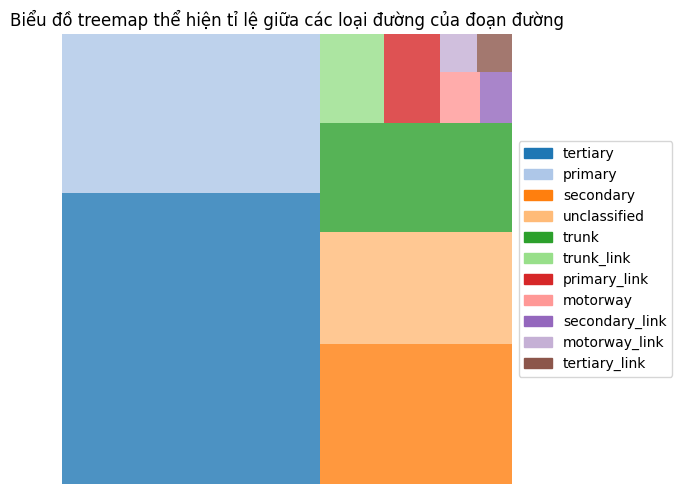

In [19]:
cmap = mpl.colormaps["tab20"]
colors = [cmap(i) for i in range(len(type_counts))]

squarify.plot(
    sizes = type_counts.values,
    alpha = 0.8,
    color = colors
)

legend_patches = [
    mpatches.Patch(color=colors[i], label=type_counts.index[i])
    for i in range(len(type_counts))
]

plt.legend(
    handles=legend_patches,
    loc="center left",
    bbox_to_anchor=(1, 0.5)
)

plt.axis('off')
plt.tight_layout()
plt.title("Biểu đồ treemap thể hiện tỉ lệ giữa các loại đường của đoạn đường")
plt.show()


Đoạn đường đô thị cấp ba chiếm số lượng nhiều nhất (1465 đoạn đường) trong khi đó nhánh vào đoạn đường đô thị cấp ba chiếm số lượng ít nhất (26 đoạn đường)

## nodes.csv

File nodes.csv gồm 577967 dòng, 3 cột gồm: id của node, vĩ dộ, kinh độ tại vị trí đặt sensor

In [28]:
nodes_df = pd.read_csv(f"{DATA_ROOT}/nodes.csv")
nodes_df.shape

(577967, 3)

In [74]:
nodes_df.head()

,_id,long,lat
0,366367223,106.629056,10.804243
1,366367233,106.709701,10.771110
2,366367242,106.737189,10.709337
3,366367274,106.760081,10.854489
4,366367285,106.721163,10.804994


In [29]:
nodes_df.isnull().sum()

_id     0
long    0
lat     0
dtype: int64

In [30]:
nodes_df.duplicated().sum()

np.int64(0)

In [73]:
nodes_df.dtypes

_id       int64
long    float64
lat     float64
dtype: object

In [33]:
long_arr = nodes_df["long"]
lat_arr = nodes_df["lat"]

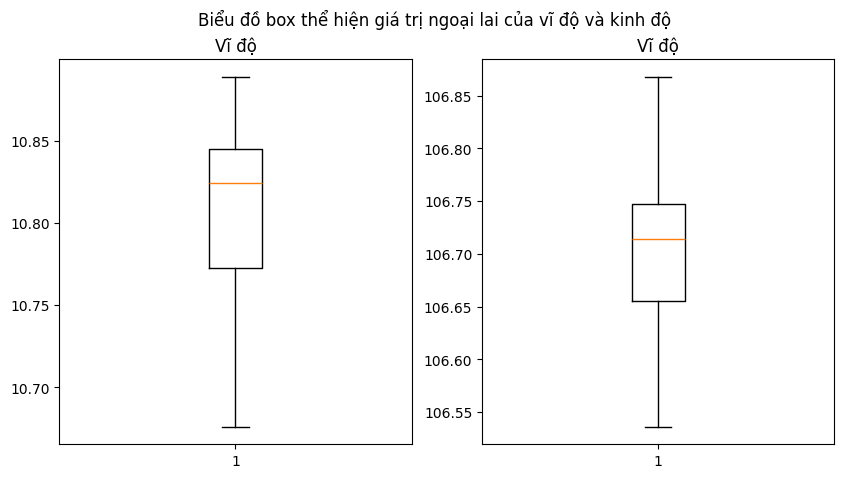

In [52]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle("Biểu đồ box thể hiện giá trị ngoại lai của vĩ độ và kinh độ")

axes[0].set_title("Vĩ độ")
axes[0].boxplot(lat_arr)

axes[1].set_title("Vĩ độ")
axes[1].boxplot(long_arr)
plt.show()

In [81]:
fig = go.Figure(data=go.Scattergeo(
        lon = long_arr[:10],
        lat = lat_arr[:10],
        ))
fig.update_layout(
        title = 'Một số vị trí đặt cảm biến trên bản đồ',
        geo_scope='asia',
    )
fig.show()

## segments.csv

In [90]:
segments_df = pd.read_csv(f"{DATA_ROOT}/segments.csv")
segments_df.shape

(84633, 11)

In [91]:
segments_df.head()

,_id,created_at,updated_at,s_node_id,e_node_id,length,street_id,max_velocity,street_level,street_name,street_type
0,0,2020-10-18T13:26:17.365Z,2020-10-18T13:26:17.365Z,373543511,5468660805,114,31096786,80.0,1,Quốc Lộ 1,trunk
1,1,2020-10-18T13:26:17.400Z,2020-10-18T13:26:17.400Z,5468660805,5738158916,9,31096786,80.0,1,Quốc Lộ 1,trunk
2,2,2020-10-18T13:26:17.435Z,2020-10-18T13:26:17.435Z,5738158916,5738158918,23,31096786,80.0,1,Quốc Lộ 1,trunk
3,3,2020-10-18T13:26:17.444Z,2020-10-18T13:26:17.444Z,5738158918,5738158912,66,31096786,80.0,1,Quốc Lộ 1,trunk
4,4,2020-10-18T13:26:17.452Z,2020-10-18T13:26:17.452Z,5738158912,5758104203,127,31096786,80.0,1,Quốc Lộ 1,trunk


In [107]:
segments_df.duplicated().sum()

np.int64(0)

In [115]:
# Số lượng các giá trị bị thiếu trong segments.csv
segments_df.isnull().sum()

_id                 0
created_at          0
updated_at          0
s_node_id           0
e_node_id           0
length              0
street_id           0
max_velocity    74762
street_level        0
street_name       152
street_type         0
dtype: int64

In [116]:
# Tỉ lệ các giá trị bị thiếu trong segments.csv
segments_df.isnull().sum()*100/len(segments_df)

_id              0.000000
created_at       0.000000
updated_at       0.000000
s_node_id        0.000000
e_node_id        0.000000
length           0.000000
street_id        0.000000
max_velocity    88.336701
street_level     0.000000
street_name      0.179599
street_type      0.000000
dtype: float64

In [95]:
preprocess_segments_df = segments_df.copy()

### Chuyển kiểu chuỗi về dạng thời gian

In [103]:
preprocess_segments_df["created_at"] = pd.to_datetime(preprocess_segments_df["created_at"])
preprocess_segments_df["updated_at"] = pd.to_datetime(preprocess_segments_df["updated_at"])
preprocess_segments_df.dtypes

_id                           int64
created_at      datetime64[ns, UTC]
updated_at      datetime64[ns, UTC]
s_node_id                     int64
e_node_id                     int64
length                        int64
street_id                     int64
max_velocity                float64
street_level                  int64
street_name                  object
street_type                  object
dtype: object

In [106]:
preprocess_segments_df.head()

,_id,created_at,updated_at,s_node_id,e_node_id,length,street_id,max_velocity,street_level,street_name,street_type
0,0,2020-10-18 13:26:17.365000+00:00,2020-10-18 13:26:17.365000+00:00,373543511,5468660805,114,31096786,80.0,1,Quốc Lộ 1,trunk
1,1,2020-10-18 13:26:17.400000+00:00,2020-10-18 13:26:17.400000+00:00,5468660805,5738158916,9,31096786,80.0,1,Quốc Lộ 1,trunk
2,2,2020-10-18 13:26:17.435000+00:00,2020-10-18 13:26:17.435000+00:00,5738158916,5738158918,23,31096786,80.0,1,Quốc Lộ 1,trunk
3,3,2020-10-18 13:26:17.444000+00:00,2020-10-18 13:26:17.444000+00:00,5738158918,5738158912,66,31096786,80.0,1,Quốc Lộ 1,trunk
4,4,2020-10-18 13:26:17.452000+00:00,2020-10-18 13:26:17.452000+00:00,5738158912,5758104203,127,31096786,80.0,1,Quốc Lộ 1,trunk


## Thời gian bắt đầu và thời gian cập nhật

### Kiểm tra khoảng thời gian giữa created_at và updated_at

In [ ]:
## 